## Import Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import seaborn as sn
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sn.set_style('whitegrid')
mp.rcParams['figure.figsize'] = (12, 6)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/train.csv')
test=pd.read_csv('/content/drive/MyDrive/test.csv')

## Check for Duplicates and NaN values

Duplicates

In [ ]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


NaN Values

In [ ]:
print(train.isna().sum())
print(test.isna().sum())

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


##Plot the Data Distribution and also Correlation Matrix

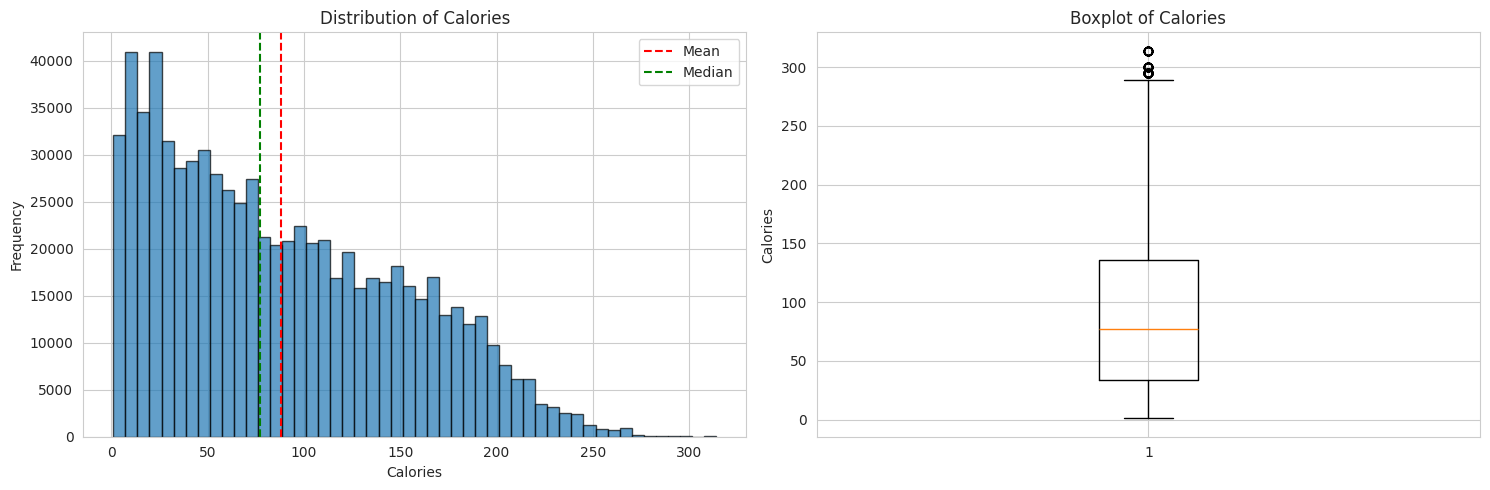

In [ ]:
# Target variable distribution
fig, axes = mp.subplots(1, 2, figsize=(15, 5))
axes[0].hist(train['Calories'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Calories')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Calories')
axes[0].axvline(train['Calories'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(train['Calories'].median(), color='green', linestyle='--', label='Median')
axes[0].legend()

axes[1].boxplot(train['Calories'])
axes[1].set_ylabel('Calories')
axes[1].set_title('Boxplot of Calories')
mp.tight_layout()
mp.show()

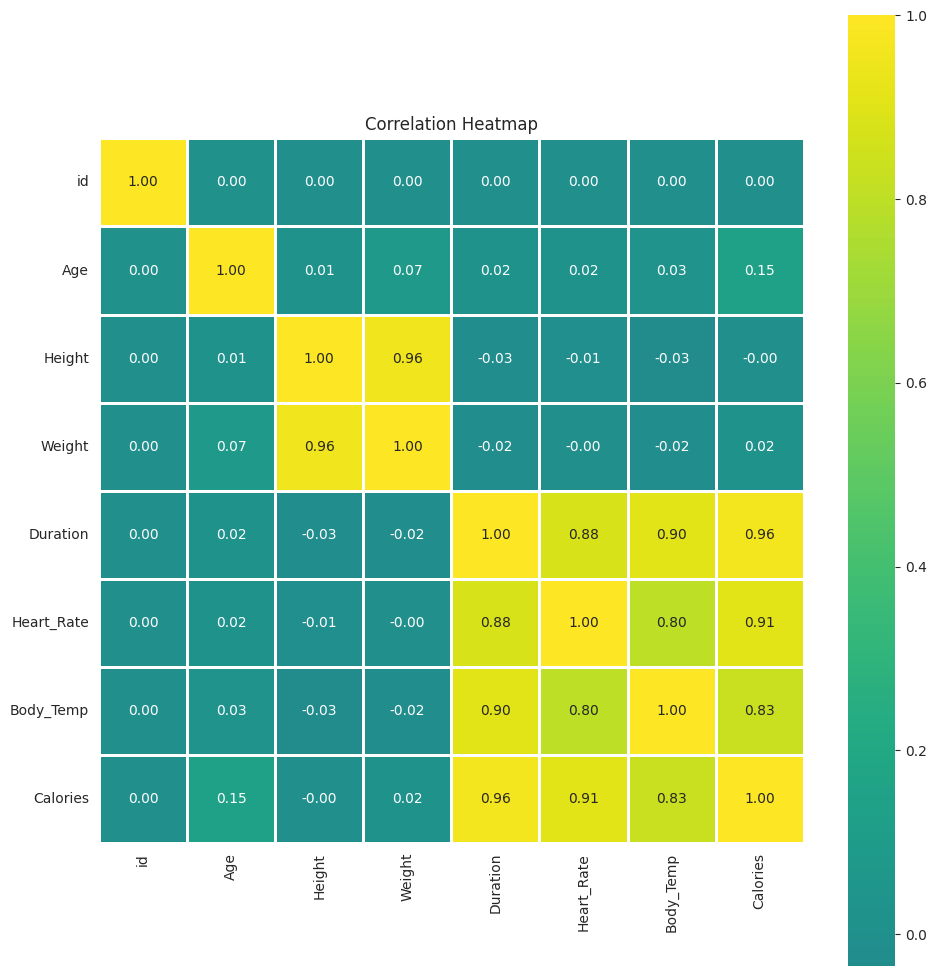

In [ ]:
numerical_cols = train.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 1:
    mp.figure(figsize=(10, 10))
    correlation_matrix = train[numerical_cols].corr()
    sn.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0,
                fmt='.2f', square=True, linewidths=1)
    mp.title('Correlation Heatmap')
    mp.tight_layout()
    mp.show()

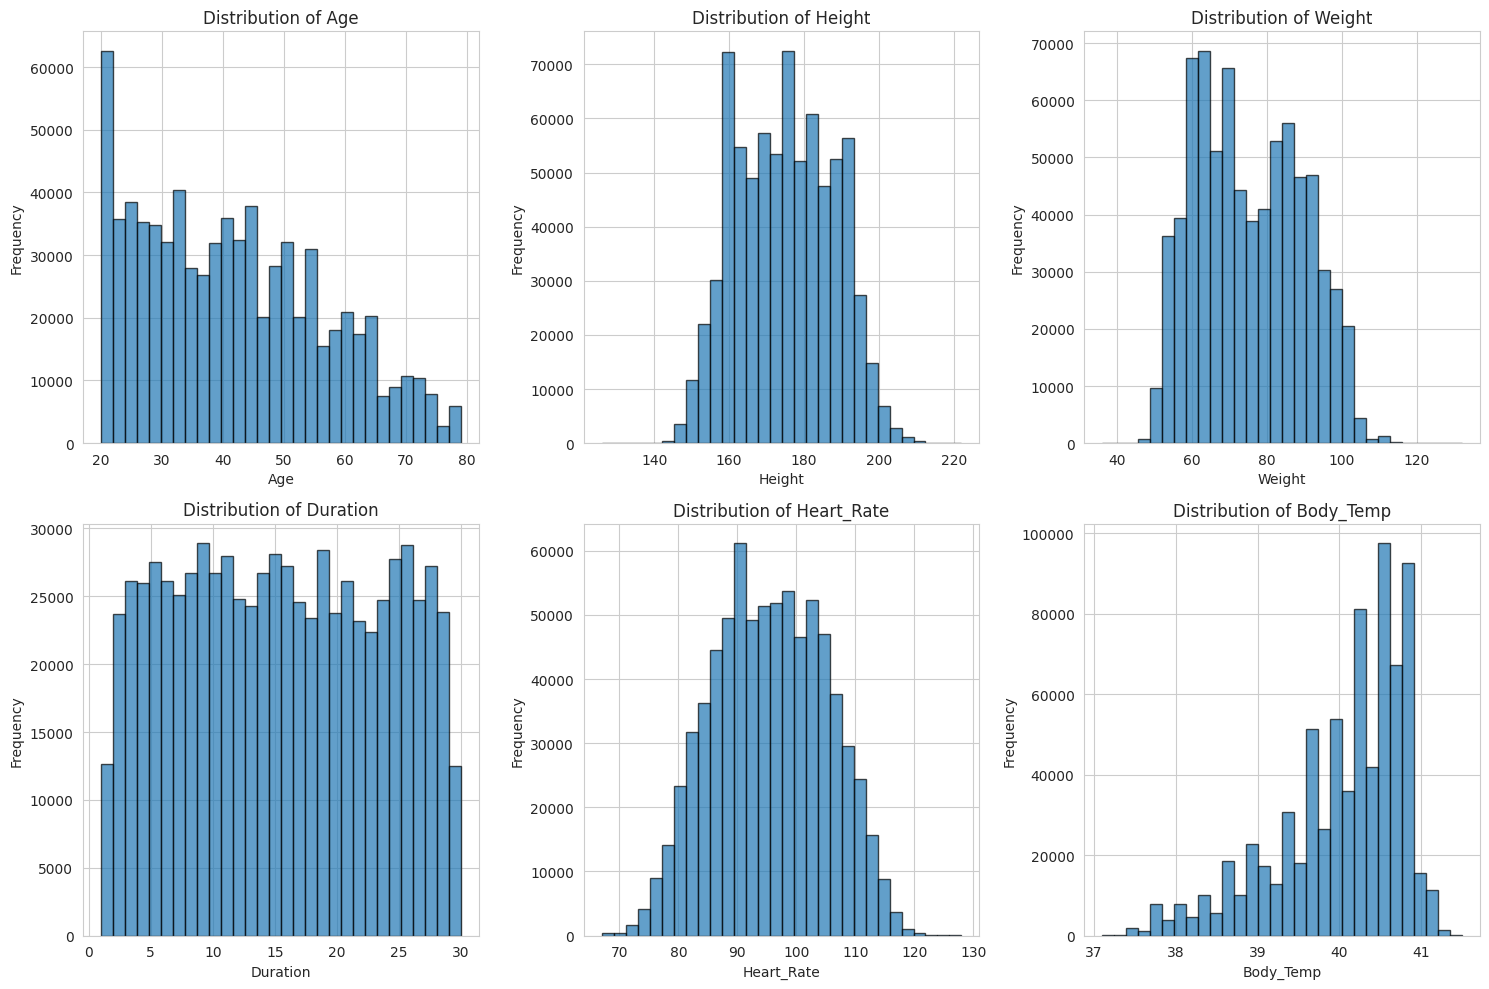

In [ ]:
num_features = [col for col in numerical_cols if col not in ['id', 'Calories']]
if len(num_features) > 0:
    n_cols = 3
    n_rows = (len(num_features) + n_cols - 1) // n_cols
    fig, axes = mp.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    for idx, col in enumerate(num_features):
        axes[idx].hist(train[col], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution of {col}')

    for idx in range(len(num_features), len(axes)):
        fig.delaxes(axes[idx])

    mp.tight_layout()

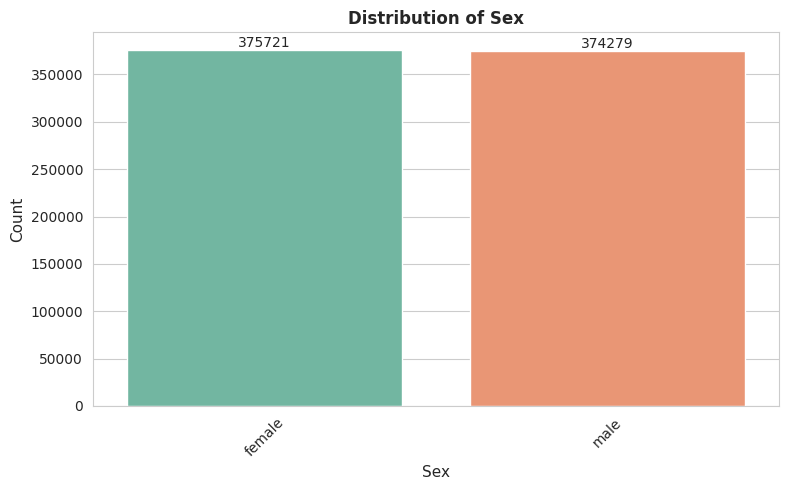

In [ ]:
# Categorical features distribution
categorical_cols = train.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'id']

if len(categorical_cols) > 0:
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    fig, axes = mp.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(categorical_cols):
        if idx < len(axes):
            value_counts = train[col].value_counts()
            sn.countplot(data=train, x=col, ax=axes[idx], palette='Set2', order=value_counts.index)
            axes[idx].set_xlabel(col, fontsize=11)
            axes[idx].set_ylabel('Count', fontsize=11)
            axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=45)

            # Add count labels on bars
            for container in axes[idx].containers:
                axes[idx].bar_label(container)

    # Remove any unused subplots
    for idx in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[idx])

    mp.tight_layout()
    mp.show()

## Outlier Removal

In [ ]:
print("\nDetecting and removing outliers using IQR method...")

def remove_outliers(df, columns, target_col='Calories'):
    """Remove outliers using Inter Quartile Range method"""
    df_clean = df.copy()
    initial_rows = len(df_clean)

    for col in columns:
        if col in df_clean.columns and col!=target_col:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1-1.5*IQR
            upper_bound = Q3+1.5*IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    # Also remove outliers from target variable
    if target_col in df_clean.columns:
        Q1 = df_clean[target_col].quantile(0.25)
        Q3 = df_clean[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1-1.5*IQR
        upper_bound = Q3+1.5*IQR
        df_clean = df_clean[(df_clean[target_col] >= lower_bound) & (df_clean[target_col] <= upper_bound)]

    removed_rows = initial_rows - len(df_clean)
    print(f"Removed {removed_rows} outlier rows ({removed_rows/initial_rows*100:.2f}%)")

    return df_clean

# Apply outlier removal to numerical features
outlier_cols = [col for col in num_features if col in train.columns]
train = remove_outliers(train, outlier_cols)

print(f"\nFinal training data shape: {train.shape}")



Detecting and removing outliers using IQR method...
Removed 15114 outlier rows (2.02%)

Final training data shape: (734886, 9)


## Feature Engineering , Scaling and Encoding

In [ ]:
X = train.drop(['Calories'], axis=1)
y = pd.DataFrame(np.log1p(train['Calories']))

In [ ]:
def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    df_new['BMI'] = df_new['Weight'] / ((df_new['Height'] / 100) ** 2)

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]

    return df_new

X = add_feature_cross_terms(X, num_features)
test = add_feature_cross_terms(test, num_features)

In [ ]:
# Identify feature types
id_cols = ['id'] if 'id' in X.columns else []
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in id_cols]
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


# For numerical features: StandardScaler
# For categorical features: OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         categorical_features)
    ],
    remainder='drop'  # Drop id column
)



Numerical features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight', 'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp', 'Heart_Rate_x_Body_Temp']
Categorical features: ['Sex']


In [ ]:
test.columns

Index(['id', 'Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration',
       'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight',
       'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp',
       'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp',
       'Duration_x_Heart_Rate', 'Duration_x_Body_Temp',
       'Heart_Rate_x_Body_Temp'],
      dtype='object')

In [ ]:
print("\n" + "="*80)
print("MODEL TRAINING WITH K-FOLD CROSS-VALIDATION")
print("="*80)
# Configuration
FOLDS = 15
FEATURES = X.columns.tolist()

# Prepare test data
X_test = test.drop(['id'], axis=1, errors='ignore')

# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Apply preprocessing to all data
print("\nApplying preprocessing pipeline...")
preprocessing_pipeline.fit(X)
X_transformed = preprocessing_pipeline.transform(X)
X_test_transformed = preprocessing_pipeline.transform(X_test)

# Convert to DataFrame for easier handling
feature_names_after_preprocessing = (
    numerical_features +
    list(preprocessing_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

X_processed = pd.DataFrame(X_transformed, columns=feature_names_after_preprocessing, index=X.index)
X_test_processed = pd.DataFrame(X_test_transformed, columns=feature_names_after_preprocessing, index=X_test.index)

print(f"Processed features shape: {X_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")
print(f"\nPreprocessing Pipeline Steps:")
print(f"  1. StandardScaler for numerical features: {numerical_features}")
print(f"  2. OneHotEncoder for categorical features: {categorical_features}")

# KFold setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Arrays to store predictions
oof = np.zeros(len(X_processed))
pred = np.zeros(len(X_test_processed))
fold_scores = []

# Start CV loop
print(f"\n{'='*80}")
print(f"Starting {FOLDS}-Fold Cross-Validation")
print(f"{'='*80}")

for i, (train_idx, valid_idx) in enumerate(kf.split(X_processed, y)):
    print(f"\n{'#'*10} Fold {i+1}/{FOLDS} {'#'*10}")

    x_train = X_processed.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]
    x_valid = X_processed.iloc[valid_idx].copy()
    y_valid = y.iloc[valid_idx]
    x_test = X_test_processed.copy()

    start = time.time()

    # Train model
    model = XGBRegressor(
        device="cuda:1",  # Use "cpu" if CUDA not available
        max_depth=10,
        colsample_bytree=0.75,
        subsample=0.9,
        n_estimators=2000,
        learning_rate=0.02,
        gamma=0.01,
        max_delta_step=2,
        early_stopping_rounds=100,
        eval_metric="rmse",
        enable_categorical=True,
        random_state=42
    )

    try:
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=100
        )
    except:
        # Fallback to CPU if CUDA fails
        print("CUDA not available, falling back to CPU...")
        model = XGBRegressor(
            device="cpu",
            max_depth=10,
            colsample_bytree=0.75,
            subsample=0.9,
            n_estimators=2000,
            learning_rate=0.02,
            gamma=0.01,
            max_delta_step=2,
            early_stopping_rounds=100,
            eval_metric="rmse",
            enable_categorical=True,
            random_state=42
        )
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=100
        )

    # Predict OOF and test
    oof[valid_idx] = model.predict(x_valid)
    pred += model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
    fold_scores.append(rmse)
    print(f"\nFold {i+1} RMSE: {rmse:.4f}")
    print(f"Training time: {time.time() - start:.1f} sec")




MODEL TRAINING WITH K-FOLD CROSS-VALIDATION

Applying preprocessing pipeline...
Processed features shape: (734886, 23)
Processed test shape: (250000, 23)

Preprocessing Pipeline Steps:
  1. StandardScaler for numerical features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight', 'Height_x_Duration', 'Height_x_Heart_Rate', 'Height_x_Body_Temp', 'Weight_x_Duration', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp', 'Heart_Rate_x_Body_Temp']
  2. OneHotEncoder for categorical features: ['Sex']

Starting 15-Fold Cross-Validation

########## Fold 1/15 ##########
[0]	validation_0-rmse:0.87758
[100]	validation_0-rmse:0.13141
[200]	validation_0-rmse:0.05969
[300]	validation_0-rmse:0.05748
[400]	validation_0-rmse:0.05742
[500]	validation_0-rmse:0.05743
[504]	validation_0-rmse:0.05743

Fold 1 RMSE: 0.0574
Training time: 13

In [ ]:
# Average test predictions
pred /= FOLDS
# Final RMSE
full_rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\n{'='*80}")
print(f"CROSS-VALIDATION RESULTS")
print(f"{'='*80}")
print(f"Final OOF RMSE: {full_rmse:.4f}")
print(f"Mean Fold RMSE: {np.mean(fold_scores):.4f}")
print(f"Std Fold RMSE: {np.std(fold_scores):.4f}")
print(f"Min Fold RMSE: {np.min(fold_scores):.4f}")
print(f"Max Fold RMSE: {np.max(fold_scores):.4f}")




CROSS-VALIDATION RESULTS
Final OOF RMSE: 0.0564
Mean Fold RMSE: 0.0564
Std Fold RMSE: 0.0010
Min Fold RMSE: 0.0546
Max Fold RMSE: 0.0580


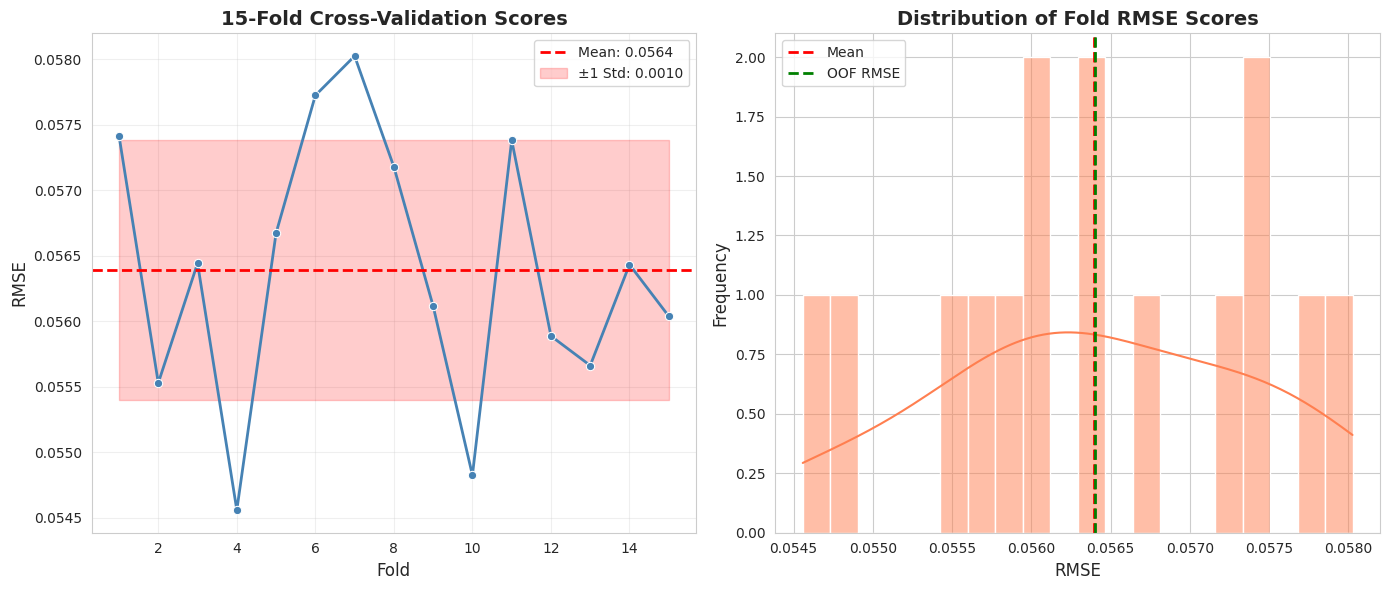

In [ ]:
# Visualize CV scores
mp.figure(figsize=(14, 6))
mp.subplot(1, 2, 1)
sn.lineplot(x=range(1, FOLDS+1), y=fold_scores, marker='o', linewidth=2, markersize=6, color='steelblue')
mp.axhline(y=np.mean(fold_scores), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(fold_scores):.4f}')
mp.fill_between(range(1, FOLDS+1),
                 np.mean(fold_scores) - np.std(fold_scores),
                 np.mean(fold_scores) + np.std(fold_scores),
                 alpha=0.2, color='red', label=f'±1 Std: {np.std(fold_scores):.4f}')
mp.xlabel('Fold', fontsize=12)
mp.ylabel('RMSE', fontsize=12)
mp.title(f'{FOLDS}-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
mp.legend(fontsize=10)
mp.grid(True, alpha=0.3)

# Plot 2: Distribution of fold scores
mp.subplot(1, 2, 2)
sn.histplot(fold_scores, bins=20, kde=True, color='coral')
mp.axvline(np.mean(fold_scores), color='red', linestyle='--', linewidth=2, label='Mean')
mp.axvline(full_rmse, color='green', linestyle='--', linewidth=2, label='OOF RMSE')
mp.xlabel('RMSE', fontsize=12)
mp.ylabel('Frequency', fontsize=12)
mp.title('Distribution of Fold RMSE Scores', fontsize=14, fontweight='bold')
mp.legend(fontsize=10)

mp.tight_layout()
mp.show()


In [ ]:
# ============================================================================
# 7. GENERATE PREDICTIONS AND SUBMISSION
# ============================================================================
print("\n" + "="*80)
print("GENERATING PREDICTIONS")
print("="*80)
pred = np.expm1(pred)
print(f"Predictions shape: {pred.shape}")
print(f"Sample predictions: {pred[:5]}")

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Calories': pred
})



GENERATING PREDICTIONS
Predictions shape: (250000,)
Sample predictions: [ 27.5443457  108.10277956  87.58286483 125.68851312  75.95897559]


In [ ]:
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")
print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head(10))



Submission file created: submission.csv
Submission shape: (250000, 2)

First few predictions:
       id    Calories
0  750000   27.544346
1  750001  108.102780
2  750002   87.582865
3  750003  125.688513
4  750004   75.958976
5  750005   21.716586
6  750006   48.268698
7  750007    6.824576
8  750008   10.061540
9  750009  204.984392



FEATURE IMPORTANCE (Last Fold Model)

Top 20 Most Important Features:
                   feature  importance
19   Duration_x_Heart_Rate    0.572990
3                 Duration    0.332705
20    Duration_x_Body_Temp    0.069229
9           Age_x_Duration    0.004444
22                Sex_male    0.003523
10        Age_x_Heart_Rate    0.003437
21  Heart_Rate_x_Body_Temp    0.002408
8             Age_x_Weight    0.001894
11         Age_x_Body_Temp    0.001864
4               Heart_Rate    0.001820
13       Height_x_Duration    0.001789
7             Age_x_Height    0.000814
0                      Age    0.000802
14     Height_x_Heart_Rate    0.000597
2                   Weight    0.000479
18      Weight_x_Body_Temp    0.000282
17     Weight_x_Heart_Rate    0.000240
16       Weight_x_Duration    0.000206
12         Height_x_Weight    0.000129
5                Body_Temp    0.000099


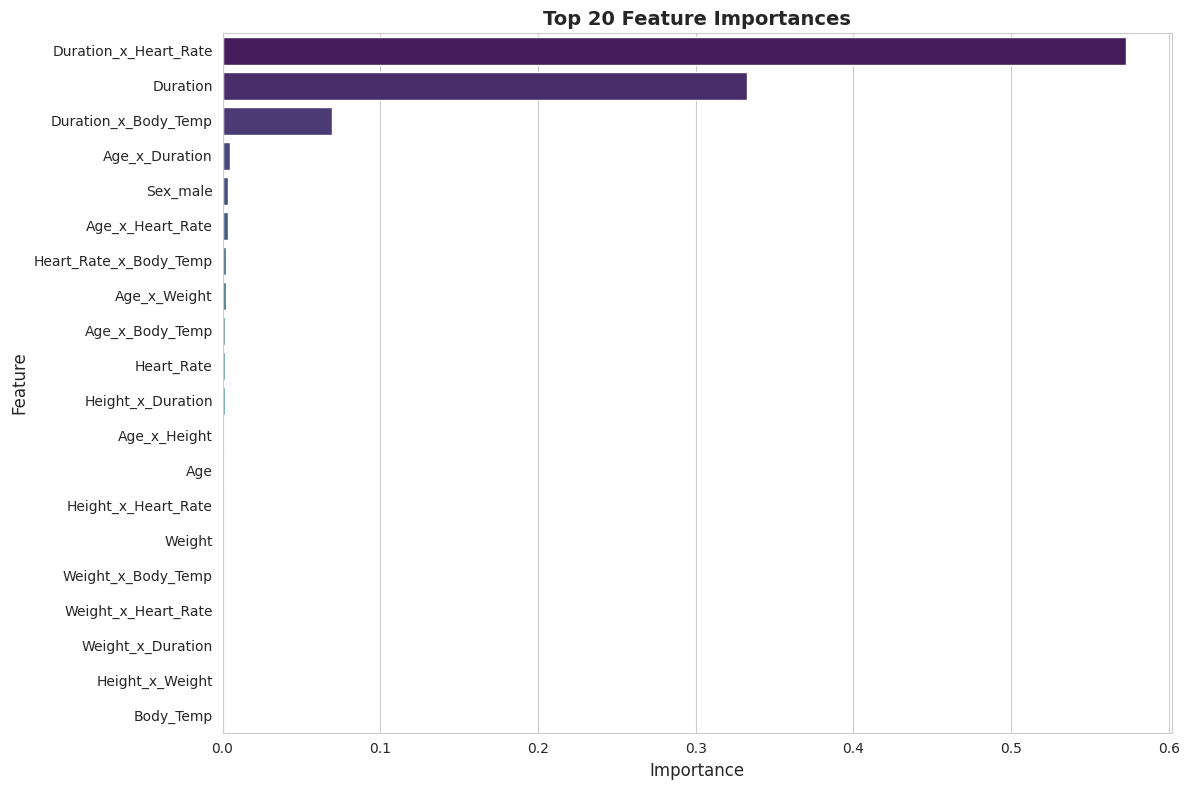

In [ ]:
# ============================================================================
# 8. FEATURE IMPORTANCE (from last fold model)
# ============================================================================
print("\n" + "="*80)
print("FEATURE IMPORTANCE (Last Fold Model)")
print("="*80)

# Get feature importance from the last trained model
feature_importance = model.feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names_after_preprocessing,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Plot feature importance
mp.figure(figsize=(12, 8))
top_n = min(20, len(importance_df))
colors = sn.color_palette("viridis", top_n)
sn.barplot(data=importance_df.head(top_n), y='feature', x='importance',
            palette=colors, orient='h')
mp.xlabel('Importance', fontsize=12)
mp.ylabel('Feature', fontsize=12)
mp.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
mp.tight_layout()
mp.show()


In [ ]:
y.values.flatten()

array([5.01727984, 3.55534806, 3.40119738, ..., 5.40267738, 4.70048037,
       4.6443909 ])

In [ ]:
oof

array([4.99472427, 3.61481857, 3.40579653, ..., 5.44772053, 4.67910242,
       4.61875725])


OUT-OF-FOLD PREDICTIONS ANALYSIS

OOF Predictions Statistics:
              actual      predicted       residual
count  734886.000000  734886.000000  734886.000000
mean        4.193456       4.193482      -0.000026
std         0.896678       0.894560       0.056402
min         0.693147       0.907408      -2.366787
25%         3.610918       3.622426      -0.019073
50%         4.382027       4.378037       0.001004
75%         4.927254       4.926802       0.020876
max         5.662960       5.619669       2.573123


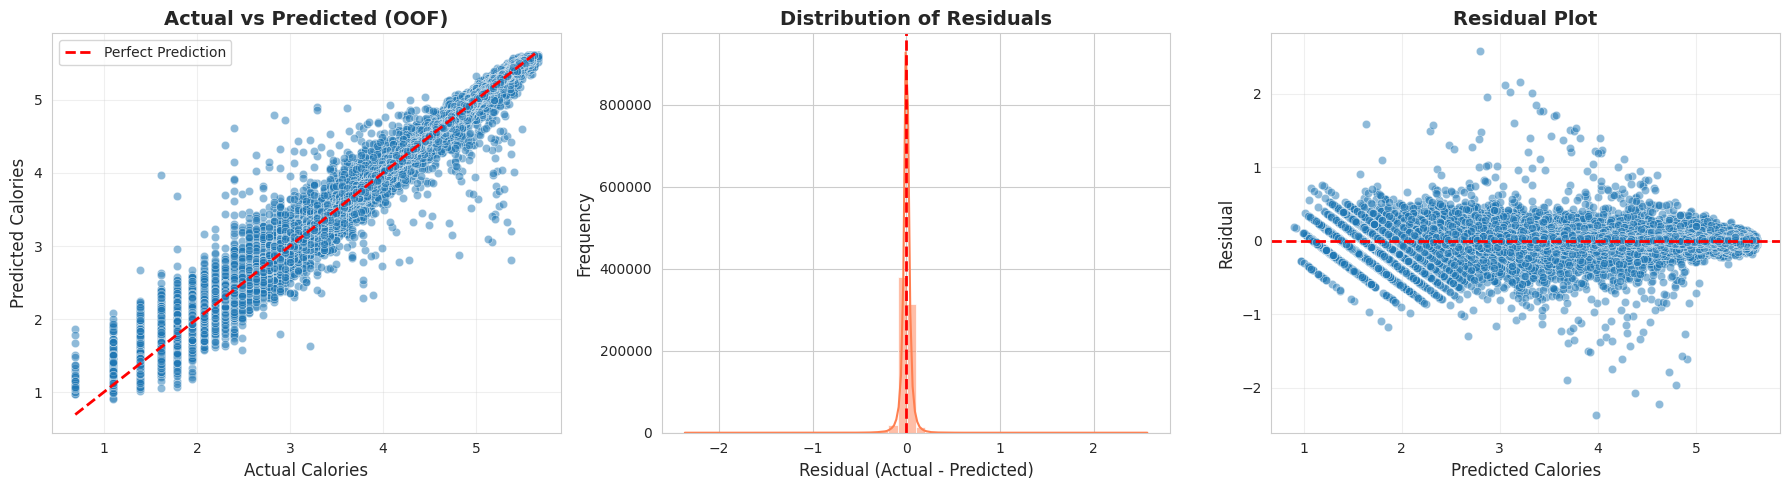


PIPELINE COMPLETE!


In [ ]:
# ============================================================================
# 9. OOF PREDICTIONS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("OUT-OF-FOLD PREDICTIONS ANALYSIS")
print("="*80)

# Create OOF DataFrame
oof_df = pd.DataFrame({
    'actual': y.values.flatten(),
    'predicted': oof
})
oof_df['residual'] = oof_df['actual'] - oof_df['predicted']

print("\nOOF Predictions Statistics:")
print(oof_df.describe())

# Visualize OOF predictions
fig, axes = mp.subplots(1, 3, figsize=(18, 5))

# Actual vs Predicted
sn.scatterplot(data=oof_df, x='actual', y='predicted', alpha=0.5, ax=axes[0])
axes[0].plot([oof_df['actual'].min(), oof_df['actual'].max()],
             [oof_df['actual'].min(), oof_df['actual'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Calories', fontsize=12)
axes[0].set_ylabel('Predicted Calories', fontsize=12)
axes[0].set_title('Actual vs Predicted (OOF)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals distribution
sn.histplot(oof_df['residual'], bins=50, kde=True, ax=axes[1], color='coral')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residual (Actual - Predicted)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')

# Residuals vs Predicted
sn.scatterplot(data=oof_df, x='predicted', y='residual', alpha=0.5, ax=axes[2])
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Predicted Calories', fontsize=12)
axes[2].set_ylabel('Residual', fontsize=12)
axes[2].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

mp.tight_layout()
mp.show()

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)